# EDA

In [92]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import random
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from scipy.stats import norm, skew

from scipy.special import boxcox1p, inv_boxcox1p

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 100)

sns.set_style("white")
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
plt.rcParams['figure.figsize'] = [16.0, 10.0]

In [2]:
dates = [
    '201902', '201903', '201904', '201905', '201907', '201908', '201909',
    '201910', '201911', '202001', '202002', '202003', '202004', '202005',
    '202007', '202008', '202009', '202010', '202011'
]
seed=111
p = 0.2
bc_dataframe = []
for date in dates:
    df = pd.read_csv(
             f"train_{date}_cleaned.csv",
             header=0,
             skiprows=lambda i: i>0 and random.random() > p
    ).drop("Unnamed: 0", axis=1)
    bc_dataframe.append(df)
bc_dataframe = pd.concat(bc_dataframe, axis=0)

In [147]:
bc_dataframe['periodo'] =bc_dataframe['periodo'].astype(str)

bc_dataframe['total_cuota'] = bc_dataframe['cuota_cred_hipot'] + \
                                   bc_dataframe['cuota_tarjeta_de_credito'] + \
                                   bc_dataframe['cuota_de_consumo'] + \
                                   bc_dataframe['cuota_rotativos'] + \
                                   bc_dataframe['cuota_de_sector_solidario'] + \
                                   bc_dataframe['cuota_libranza_sf'] + \
                                   bc_dataframe['cuota_tarjeta_de_credito'] + \
                                   bc_dataframe['cuota_tc_bancolombia']
pct_vars = [
            'cuota_cred_hipot',
            'cuota_tarjeta_de_credito',
            'cuota_de_consumo',
            'cuota_rotativos',
            'cuota_sector_real_comercio',
            'cuota_de_sector_solidario',
            'cuota_tc_bancolombia',
            'cuota_libranza_sf',
            'cupo_total_tc',
            'cupo_tc_mdo'
        ]
bc_dataframe['ingreso_calculado'] =  bc_dataframe['ingreso_segurida_social']  +  \
                                          bc_dataframe[['ingreso_nompen', 'ingreso_nomina']].max(axis=1)
bc_dataframe['ingreso_corr'] = bc_dataframe[['ingreso_final', 'ingreso_calculado']].max(axis=1)

for var in pct_vars:
        bc_dataframe[f"{var}_pct"] = bc_dataframe[var] / bc_dataframe['ingreso_corr']  * 100
        bc_dataframe[f"{var}_pct"] = bc_dataframe[f"{var}_pct"].replace(dict.fromkeys([np.nan, np.inf, -np.inf], 0))

bc_dataframe['obl_total_pct'] = bc_dataframe['cuota_cred_hipot_pct'] + \
                                     bc_dataframe['cuota_tarjeta_de_credito_pct'] +\
                                     bc_dataframe['cuota_de_consumo_pct'] + \
                                     bc_dataframe['cuota_rotativos_pct'] + \
                                     bc_dataframe['cuota_sector_real_comercio_pct'] + \
                                     bc_dataframe['cuota_de_sector_solidario_pct'] + \
                                     bc_dataframe['cuota_tc_bancolombia_pct'] + \
                                     bc_dataframe['cuota_rotativos_pct'] 
bc_dataframe['sobre_endeudado'] = np.where(bc_dataframe['obl_total_pct'] > 100, 1, 0)
bc_dataframe['saldo_favor']  = np.where(bc_dataframe['total_cuota']<0, bc_dataframe['total_cuota']*-1, 0)
bc_dataframe['total_cuota'] = np.where(bc_dataframe['total_cuota']<0,0, bc_dataframe['total_cuota'])

bc_dataframe['cat_edad'] = np.where(bc_dataframe['edad'] < 30, "M30",
                                   np.where(bc_dataframe['edad'] < 40, "M30_40",
                                           np.where(bc_dataframe['edad'] < 50, "M40_50", "M60")))

In [93]:
bc_dataframe.head()

,periodo,id_cli,edad,genero,estado_civil,nivel_academico,ocupacion,tipo_vivienda,ult_actual,categoria,ind_mora_vigente,departamento_residencia,mora_max,cupo_total_tc,tenencia_tc,cuota_tc_bancolombia,tiene_consumo,tiene_crediagil,nro_tot_cuentas,ctas_activas,tiene_ctas_activas,cuota_cred_hipot,mediana_nom3,mediana_pen3,ingreso_nompen,cat_ingreso,ingreso_final,cant_mora_30_tdc_ult_3m_sf,cant_mora_30_consum_ult_3m_sf,cuota_de_vivienda,cuota_de_consumo,cuota_rotativos,cuota_tarjeta_de_credito,cuota_de_sector_solidario,cuota_sector_real_comercio,cupo_tc_mdo,saldo_prom3_tdc_mdo,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ind,rep_calif_cred,pol_centr_ext,convenio_lib,ingreso_nomina,ingreso_segurida_social,gasto_familiar,total_cuota,ingreso_calculado,ingreso_corr,cuota_cred_hipot_pct,cuota_tarjeta_de_credito_pct,cuota_de_consumo_pct,cuota_rotativos_pct,cuota_sector_real_comercio_pct,cuota_de_sector_solidario_pct,cuota_tc_bancolombia_pct,cuota_libranza_sf_pct,cupo_total_tc_pct,cupo_tc_mdo_pct,obl_total_pct,sobre_endeudado
0,201902,2897375,34,F,SOL,UNIVERSITARIO,Empleado,\N,20180526,1,N,VALLE,NApl,0.00000,0,0.00000,0,0,1,1,0,0.00000,0.00000,0.00000,0.00000,OTROS,2580312.00000,SIN MORA,SIN MORA,0.00000,220000.00000,0.00000,82000.00000,0.00000,0.00000,500000.00000,352500.00000,184000.00000,634000.00000,0.00000,2,1375202.80000,D,cumple,N,0.00000,0.00000,1932240.00000,384000.00000,0.00000,2580312.00000,0.00000,3.17791,8.52610,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,19.37750,11.70401,0
1,201902,2586131,34,M,SOL,ESPECIALIZACION,Empleado,FAMILIAR,20180510,2,N,CUNDINAMARCA,Entre 0 y 30 dias,0.00000,0,0.00000,0,0,1,1,0,0.00000,0.00000,0.00000,0.00000,OTROS,898342.00000,SIN MORA,CON MORA,0.00000,442000.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,12682000.00000,0.00000,2,-60204.65000,H,NApl,N,0.00000,0.00000,534336.00000,442000.00000,0.00000,898342.00000,0.00000,0.00000,49.20175,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,49.20175,0
2,201902,2586306,39,M,NI,NO INFORMA,Empleado,NO INFORMA,20180625,1,N,CUNDINAMARCA,Entre 0 y 30 dias,0.00000,0,0.00000,0,0,1,1,0,0.00000,1397155.00000,0.00000,1397155.00000,NOM,898277.00000,SIN MORA,SIN MORA,0.00000,0.00000,0.00000,0.00000,0.00000,356000.00000,1875000.00000,1406500.00000,150000.00000,15023000.00000,0.00000,1,4138.50000,G,cumple,S,897716.00000,0.00000,313246.00000,0.00000,1397155.00000,1397155.00000,0.00000,0.00000,0.00000,0.00000,25.48035,0.00000,0.00000,0.00000,0.00000,134.20129,25.48035,0
3,201902,2892385,33,M,SOL,ESPECIALIZACION,Otro,FAMILIAR,20181106,2,N,HUILA,Entre 0 y 30 dias,6650000.00000,1,461176.58250,1,0,1,1,0,0.00000,0.00000,0.00000,0.00000,OTROS,11325895.00000,CON MORA,CON MORA,0.00000,2934000.00000,0.00000,4244000.00000,0.00000,288000.00000,20967000.00000,3171000.00000,8055000.00000,21225000.00000,0.00000,7,-727092.47500,H,NApl,N,0.00000,0.00000,562109.74000,11883176.58250,0.00000,11325895.00000,0.00000,37.47165,25.90524,0.00000,2.54285,0.00000,4.07188,0.00000,58.71501,185.12444,69.99161,1
4,201902,2900599,57,M,SOL,SIN INFORMACION,Comerciante,\N,20181009,4,N,ATLANTICO,Entre 0 y 30 dias,0.00000,0,0.00000,0,0,1,1,0,0.00000,0.00000,0.00000,0.00000,OTROS,31793000.00000,NApl,NApl,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,20268037.50000,NApl,incumple,N,0.00000,0.00000,3683089.00000,0.00000,0.00000,31793000.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0


In [11]:
bc_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4199064 entries, 0 to 220891
Data columns (total 48 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   periodo                        object 
 1   id_cli                         int64  
 2   edad                           int64  
 3   genero                         object 
 4   estado_civil                   object 
 5   nivel_academico                object 
 6   ocupacion                      object 
 7   tipo_vivienda                  object 
 8   ult_actual                     int64  
 9   categoria                      object 
 10  ind_mora_vigente               object 
 11  departamento_residencia        object 
 12  mora_max                       object 
 13  cupo_total_tc                  float64
 14  tenencia_tc                    int64  
 15  cuota_tc_bancolombia           float64
 16  tiene_consumo                  int64  
 17  tiene_crediagil                int64  
 18  nro

<AxesSubplot:xlabel='gasto_familiar', ylabel='Density'>

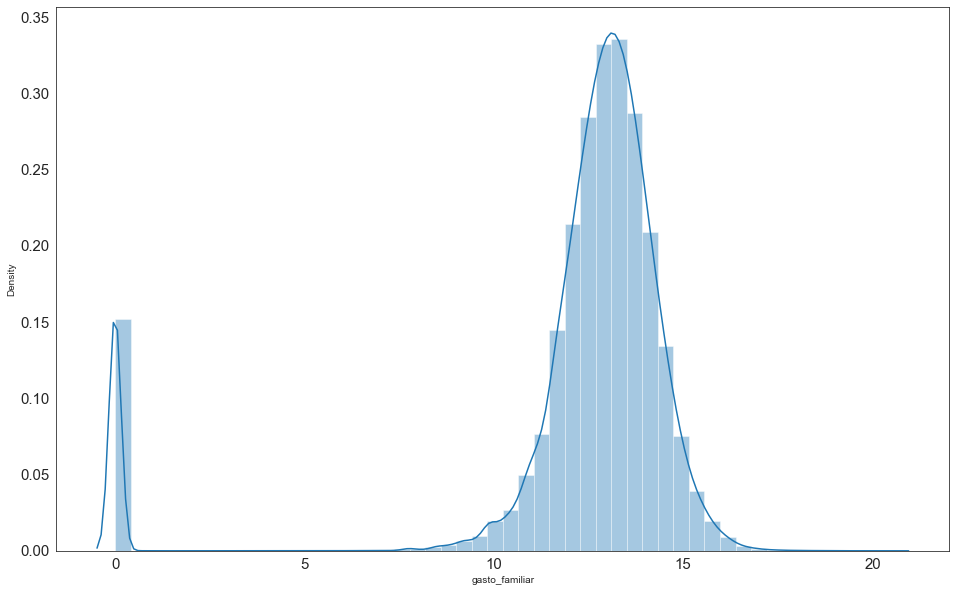

In [3]:
sns.distplot(np.log1p(bc_dataframe['gasto_familiar']))

In [14]:
bc_dataframe['periodo'].value_counts()

202001    224573
202003    224530
202002    224528
201911    223444
202007    223428
201910    223204
201909    222838
202008    222503
201908    222464
202005    222438
202009    222311
202004    221946
201907    221827
202010    221250
202011    220892
201904    216980
201905    216785
201903    214308
201902    208815
Name: periodo, dtype: int64

In [192]:
bc_dataframe.groupby('periodo')['gasto_familiar'].mean()

periodo
201902    678459.46570
201903    734561.51295
201904    709409.07677
201905    761507.63518
201907    847211.48706
201908    794376.18511
201909    801756.97631
201910    795487.01963
201911    817430.42962
202001    977419.73718
202002    933199.66939
202003    946828.47592
202004    694211.58059
202005    827328.27934
202007   1016084.32820
202008    947601.19505
202009    987531.83445
202010   1003982.52913
202011   1013725.21577
Name: gasto_familiar, dtype: float64

<AxesSubplot:xlabel='periodo'>

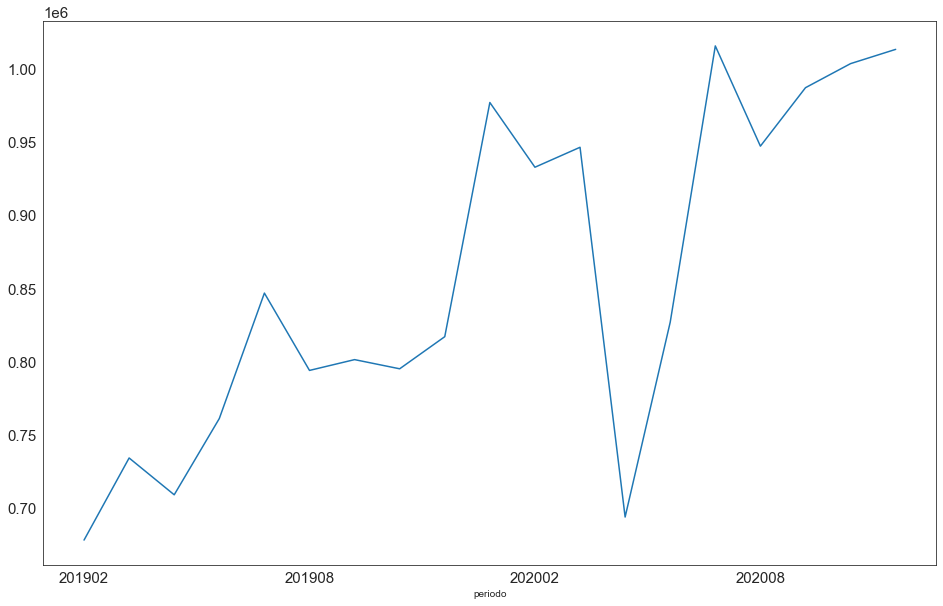

In [31]:
bc_dataframe.groupby('periodo')['gasto_familiar'].mean().plot()

Text(0.5, 1.0, 'Mediana de gastos familiares menduales')

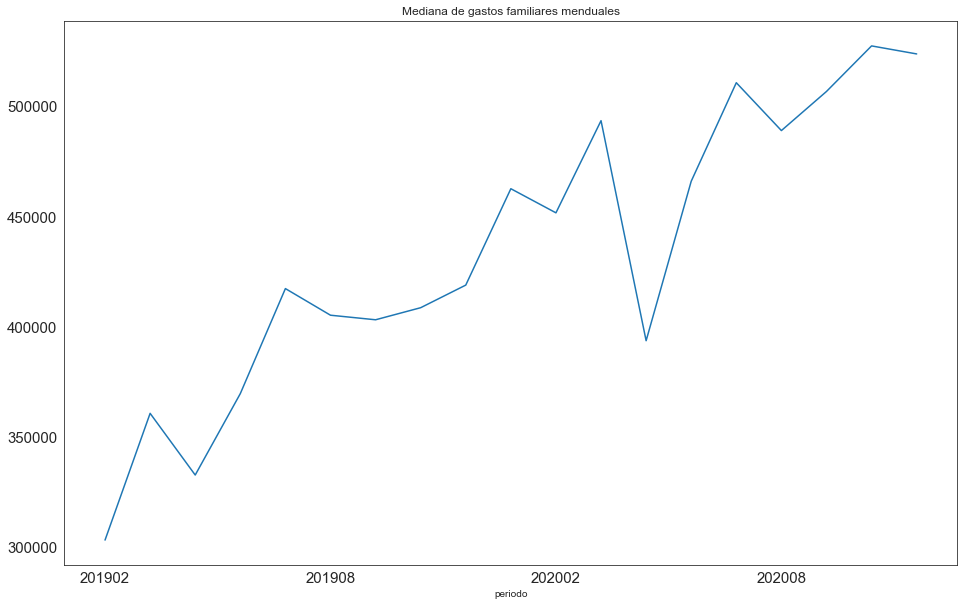

In [19]:
bc_dataframe.groupby('periodo')['gasto_familiar'].median().plot()
plt.title("Mediana de gastos familiares menduales")

Text(0.5, 1.0, 'Promedio del ingreso final mensual ')

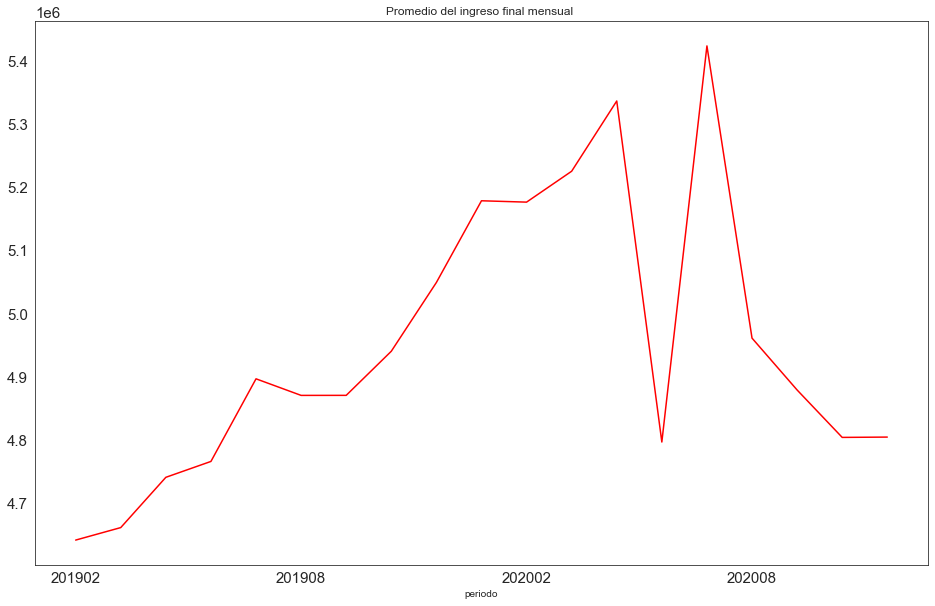

In [22]:
bc_dataframe.groupby('periodo')['ingreso_final'].mean().plot(color='red')
plt.title("Promedio del ingreso final mensual ")

Text(0.5, 1.0, 'Mediana del ingreso final')

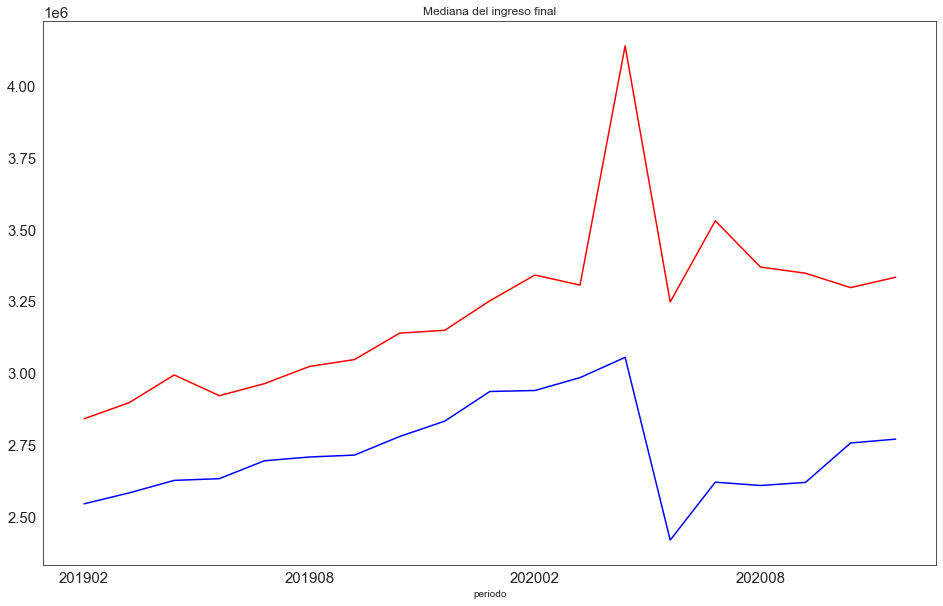

In [194]:
bc_dataframe.groupby('periodo')['ingreso_final'].median().plot(color='blue')
bc_dataframe.groupby('periodo')['ingreso_corr'].median().plot(color='red')
plt.title("Mediana del ingreso final")

Text(0.5, 1.0, 'Mediana del ingreso final')

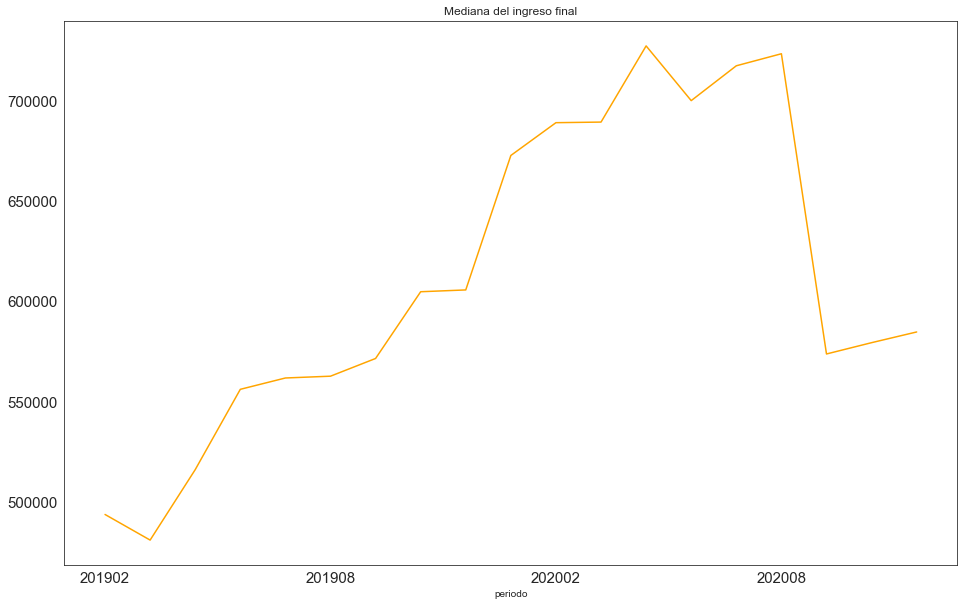

In [34]:
bc_dataframe.groupby('periodo')['total_cuota'].median().plot(color='orange')
plt.title("Mediana del Pago total de cuotas")

In [111]:
bc_dataframe.groupby('periodo')['total_cuota'].mean()

periodo
201902   1666538.05103
201903   1664594.59597
201904   1717964.45452
201905   1798797.54631
201907   1811741.72389
201908   1816469.49215
201909   1821083.94962
201910   1878942.19524
201911   1864195.78996
202001   1869363.34506
202002   1901680.58856
202003   1910437.72986
202004   2039564.11767
202005   2010601.81646
202007   2042031.70803
202008   2040401.10059
202009   1677349.01445
202010   1666412.51134
202011   1681076.14641
Name: total_cuota, dtype: float64

Text(0.5, 1.0, 'Mediana del Pago total de cuotas')

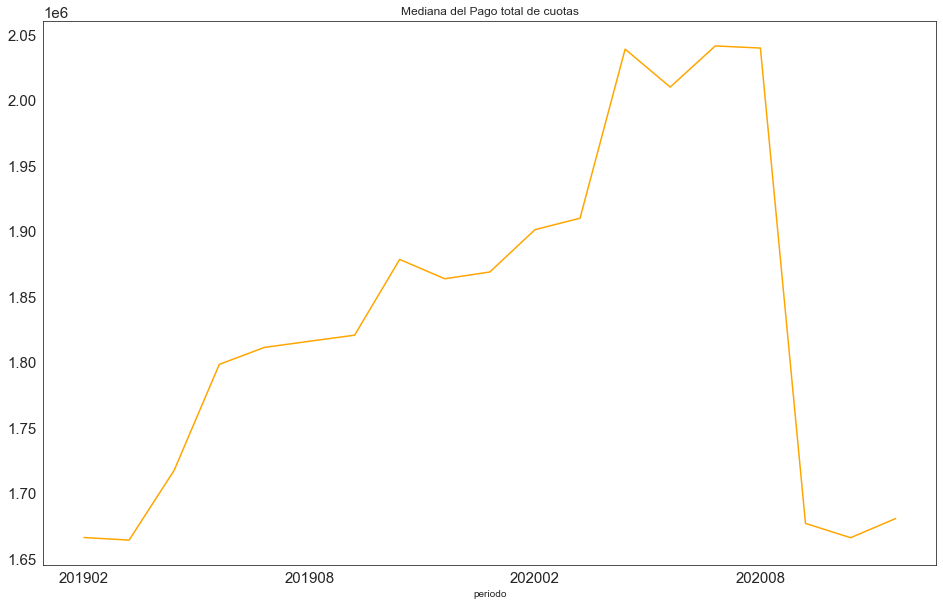

In [110]:
bc_dataframe.groupby('periodo')['total_cuota'].mean().plot(color='orange')
plt.title("Mediana del Pago total de cuotas")

Text(0.5, 1.0, 'Valor a pagar de total cuotas por estado de mora')

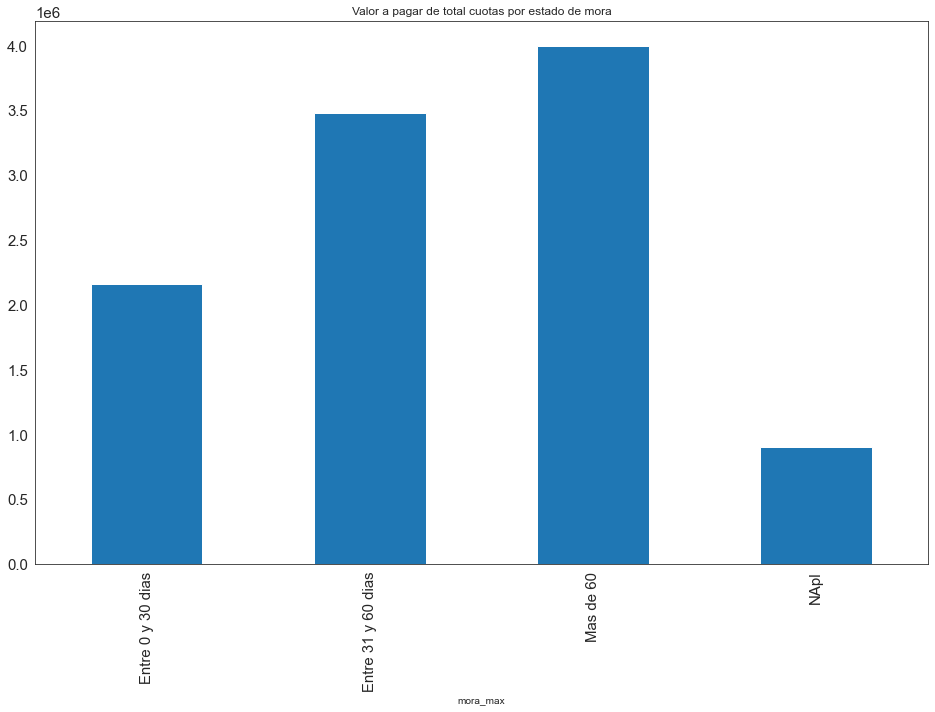

In [40]:
bc_dataframe.groupby('mora_max')['total_cuota'].mean().plot( kind='bar')
plt.title("Valor a pagar de total cuotas por estado de mora")

<AxesSubplot:xlabel='ind_mora_vigente'>

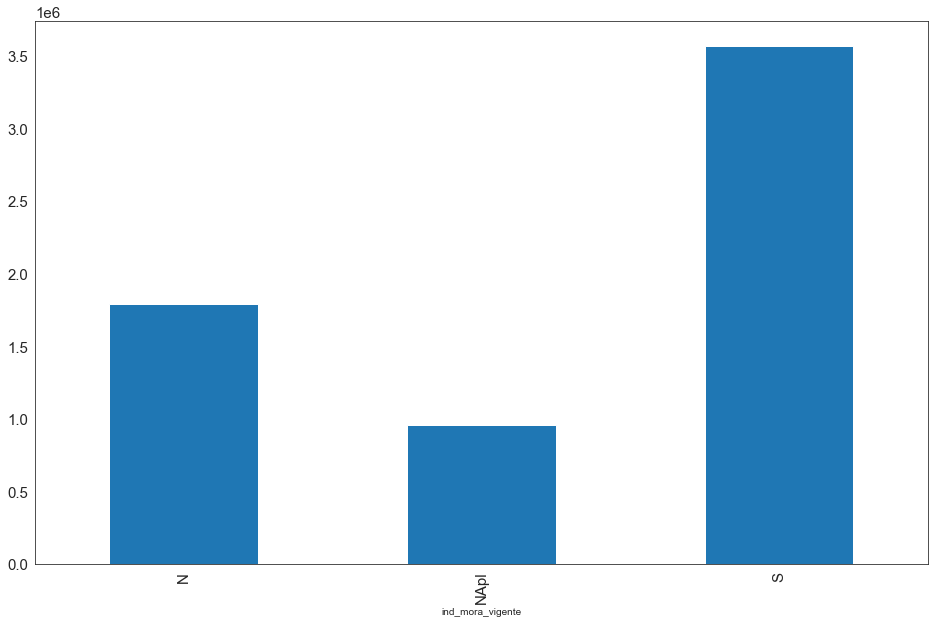

In [41]:
bc_dataframe.groupby('ind_mora_vigente')['total_cuota'].mean().plot( kind='bar')

<AxesSubplot:xlabel='ind_mora_vigente'>

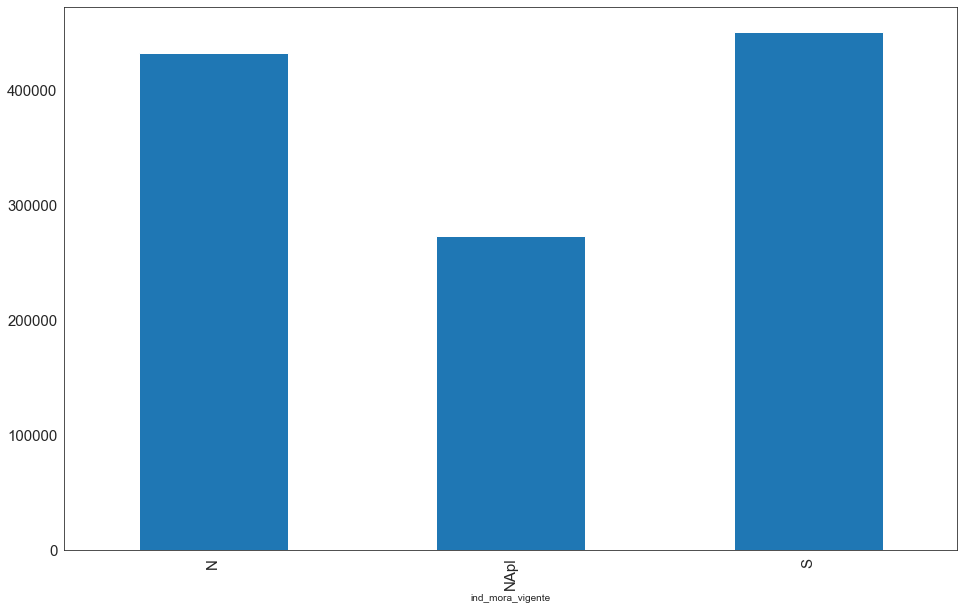

In [45]:
bc_dataframe.groupby('ind_mora_vigente')['gasto_familiar'].median().plot( kind='bar')

<AxesSubplot:xlabel='ind_mora_vigente'>

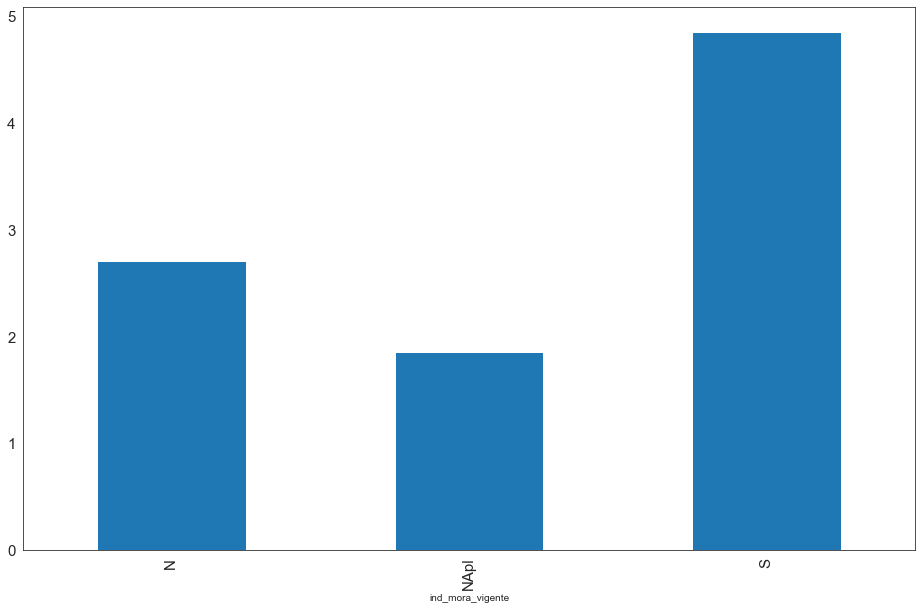

In [47]:
bc_dataframe.groupby('ind_mora_vigente')['cant_oblig_tot_sf'].mean().plot( kind='bar')

<AxesSubplot:xlabel='cant_oblig_tot_sf'>

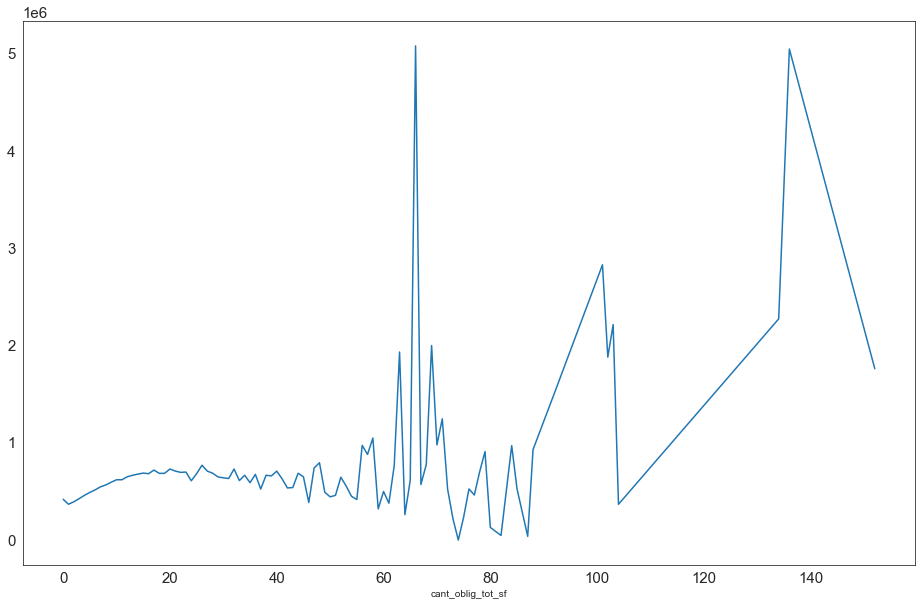

In [53]:
bc_dataframe.groupby('cant_oblig_tot_sf')['gasto_familiar'].median().plot()

Text(0.5, 1.0, 'Mediana del ingreso final')

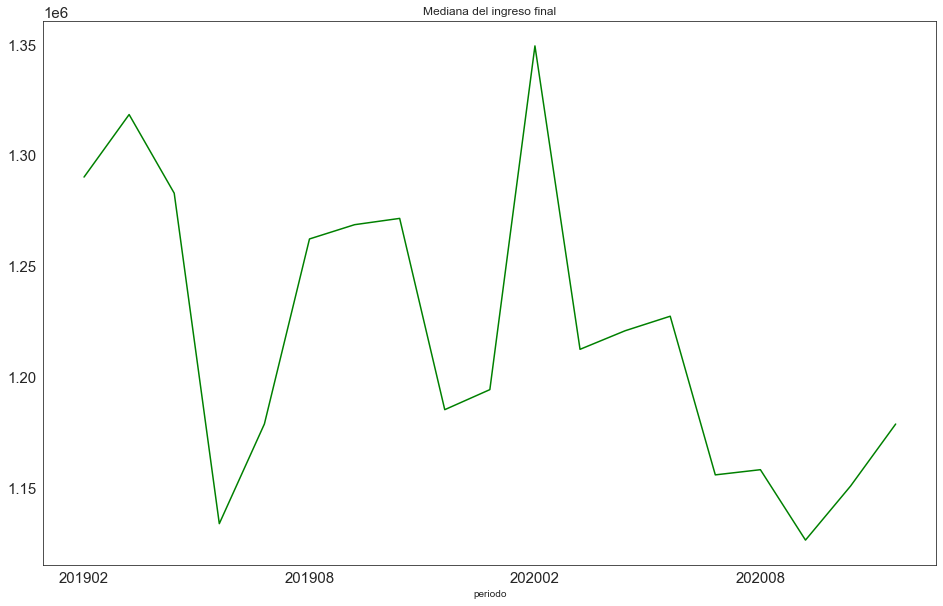

In [29]:
bc_dataframe.groupby('periodo')['ingreso_nompen'].mean().plot(color='green')
plt.title("Mediana del ingreso final")

<AxesSubplot:xlabel='obl_total_pct', ylabel='Density'>

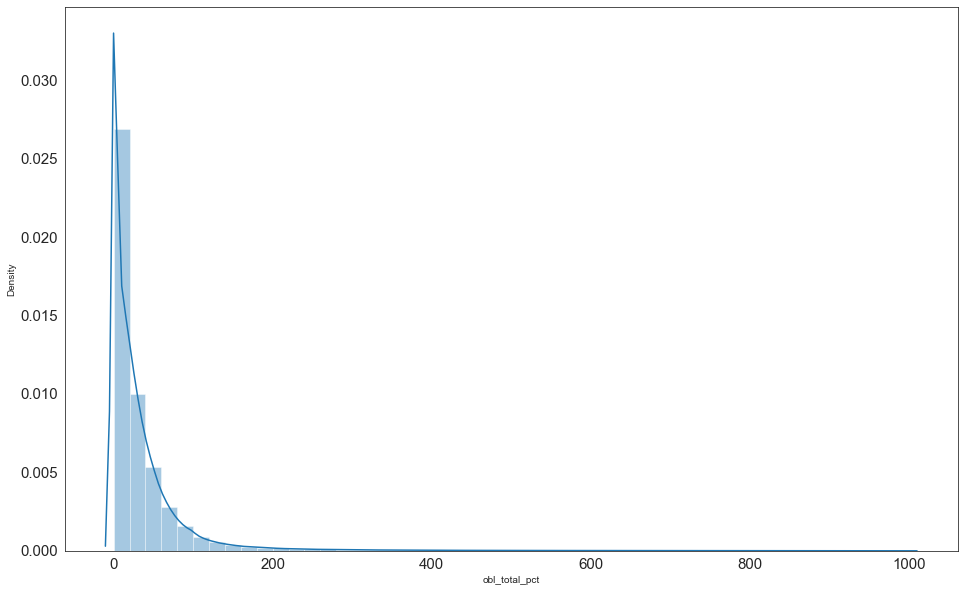

In [64]:
sns.distplot(bc_dataframe[(bc_dataframe['obl_total_pct'] < 1000) &
                          (bc_dataframe['obl_total_pct'] >=0)]['obl_total_pct'])

<AxesSubplot:xlabel='ind_mora_vigente'>

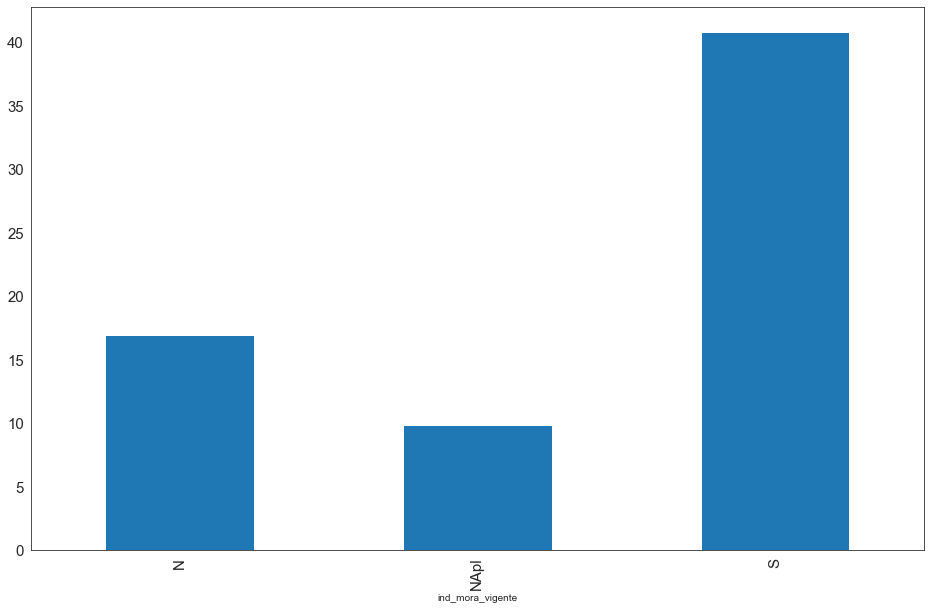

In [66]:
bc_dataframe.groupby('ind_mora_vigente')['obl_total_pct'].median().plot(kind='bar')

<AxesSubplot:xlabel='obl_total_pct', ylabel='gasto_familiar'>

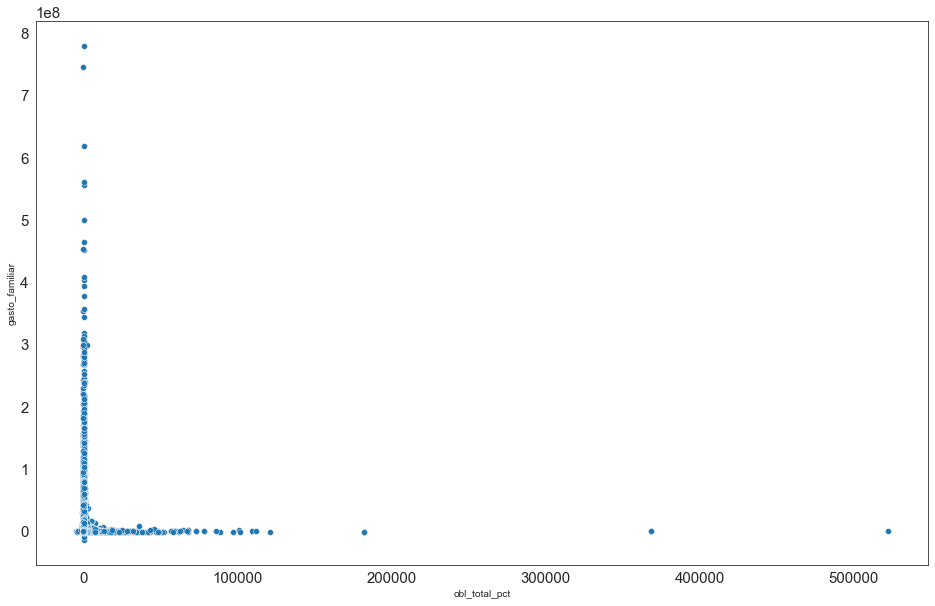

In [69]:
sns.scatterplot(bc_dataframe['obl_total_pct'], bc_dataframe['gasto_familiar'])

In [71]:
bc_dataframe[bc_dataframe['obl_total_pct'] > 100].shape

(308528, 62)

<AxesSubplot:xlabel='sobre_endeudado'>

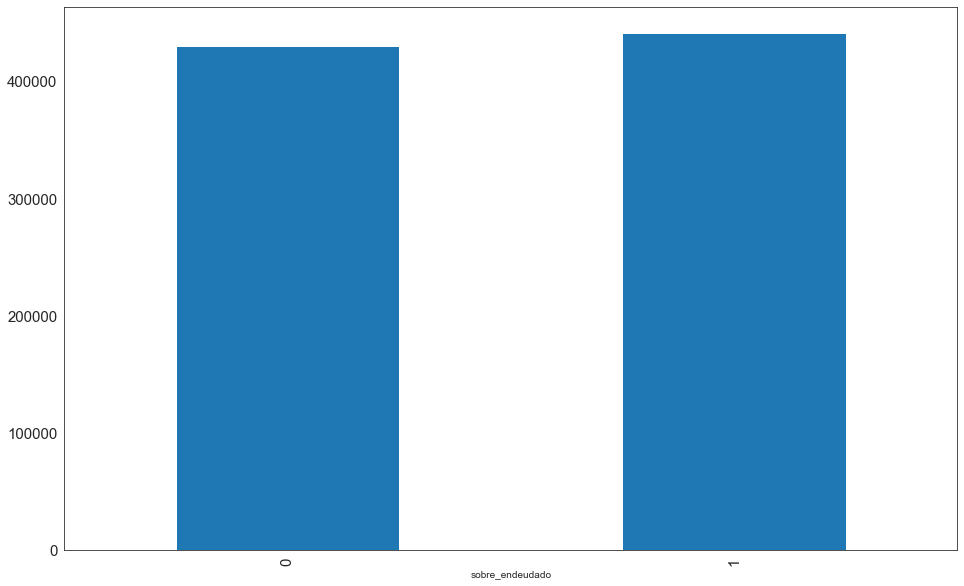

In [91]:
bc_dataframe['sobre_endeudado'] = np.where(bc_dataframe['obl_total_pct'] > 50, 1, 0)
bc_dataframe.groupby('sobre_endeudado')['gasto_familiar'].median().plot(kind='bar')

In [87]:
bc_dataframe[['obl_total_pct','saldo_no_rot_mdo', 'gasto_familiar']].corr()

,obl_total_pct,saldo_no_rot_mdo,gasto_familiar
obl_total_pct,1.00000,0.13416,-0.00184
saldo_no_rot_mdo,0.13416,1.00000,0.03121
gasto_familiar,-0.00184,0.03121,1.00000


In [86]:
bc_dataframe['saldo_no_rot_mdo'].describe()

count       4199064.00000
mean       19991681.72002
std        80862176.45969
min               0.00000
25%               0.00000
50%          124000.00000
75%        13390000.00000
max     46611782000.00000
Name: saldo_no_rot_mdo, dtype: float64

<AxesSubplot:xlabel='obl_total_pct', ylabel='saldo_no_rot_mdo'>

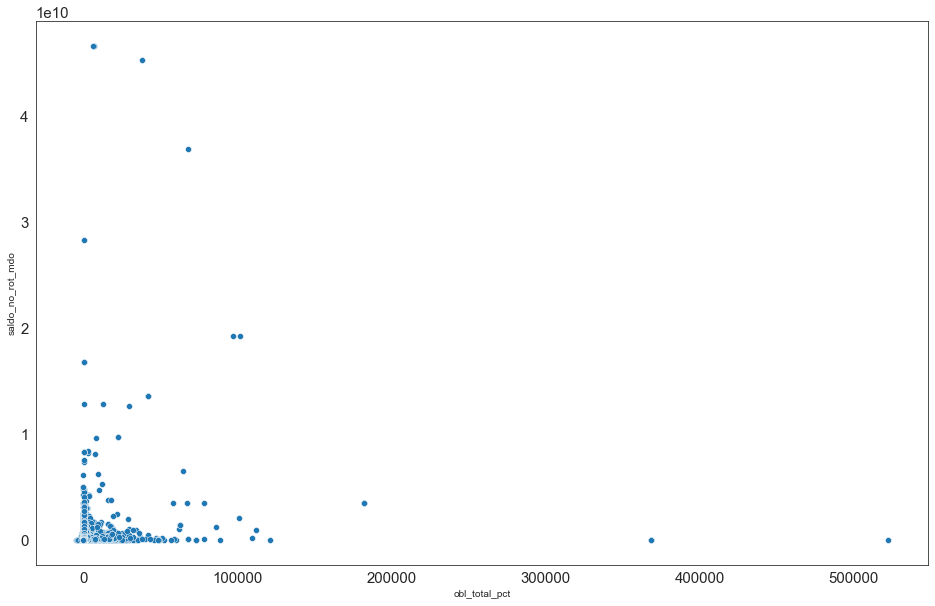

In [77]:
sns.scatterplot(bc_dataframe['obl_total_pct'], bc_dataframe['saldo_no_rot_mdo'])

In [94]:
bc_dataframe[['ind', 'gasto_familiar']].corr()

,ind,gasto_familiar
ind,1.00000,0.02254
gasto_familiar,0.02254,1.00000


In [98]:
bc_dataframe['saldo_prom3_tdc_mdo'].describe()

count       4199064.00000
mean        2087042.29933
std        18849469.70134
min               0.00000
25%               0.00000
50%               0.00000
75%         1225500.00000
max     21056050000.00000
Name: saldo_prom3_tdc_mdo, dtype: float64

<AxesSubplot:xlabel='gasto_pct', ylabel='Density'>

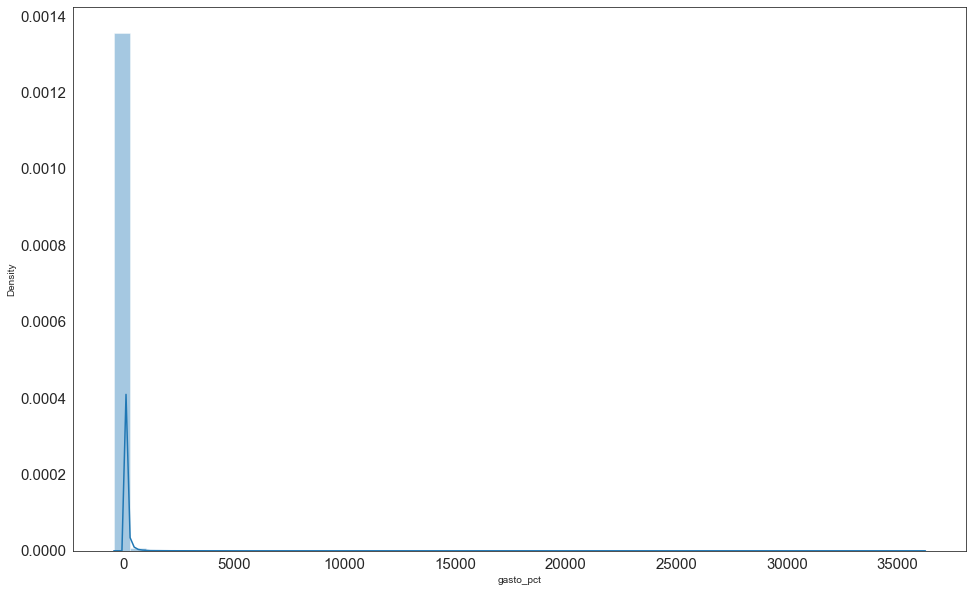

In [107]:
bc_dataframe['gasto_pct'] = (bc_dataframe['gasto_familiar'] / bc_dataframe['ingreso_corr']) *100
bc_dataframe['gasto_pct'] = bc_dataframe['gasto_pct'].replace([np.nan, np.inf], 0)

<AxesSubplot:xlabel='gasto_familiar', ylabel='Density'>

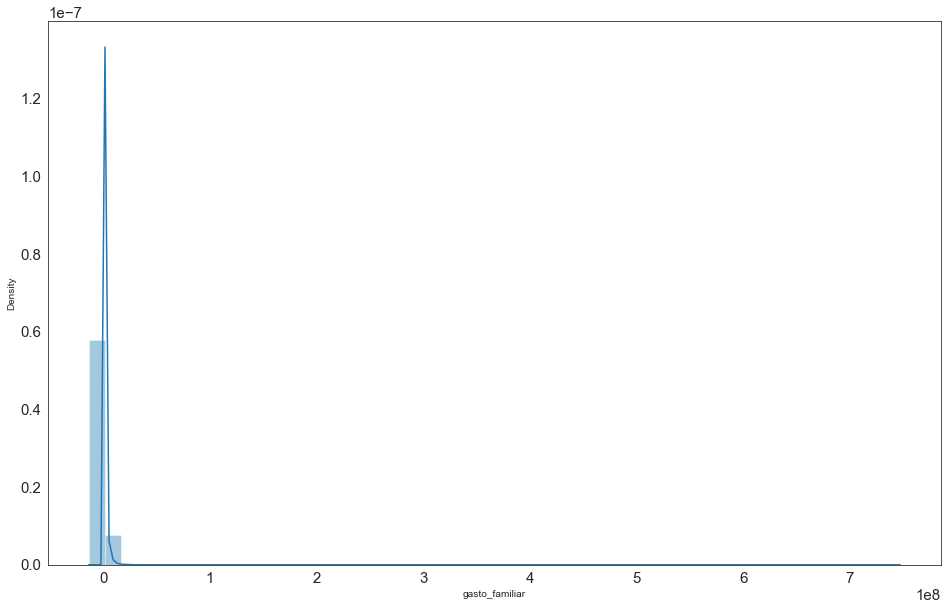

In [108]:
sns.distplot(bc_dataframe[bc_dataframe['gasto_pct'] < 1000]['gasto_familiar'])

In [109]:
bc_dataframe['gasto_pct'].describe()

count   4199064.00000
mean         26.71418
std          84.54863
min        -422.74425
25%           5.00321
50%          12.89955
75%          28.02780
max       36249.45708
Name: gasto_pct, dtype: float64

<AxesSubplot:xlabel='cat_ingreso'>

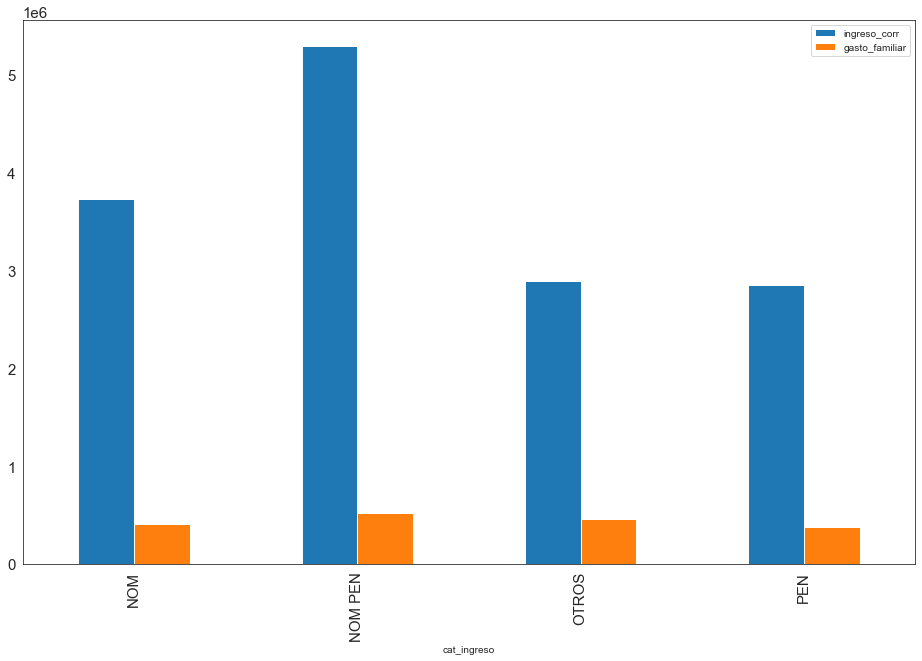

In [104]:
bc_dataframe.groupby('cat_ingreso')[['ingreso_corr', 'gasto_familiar']].median().plot(kind='bar')

In [ ]:
saldo_prom3_tdc_mdo
cupo_tc_mdo
nro_tot_cuentas

In [96]:
bc_dataframe.describe(include='all')

,periodo,id_cli,edad,genero,estado_civil,nivel_academico,ocupacion,tipo_vivienda,ult_actual,categoria,ind_mora_vigente,departamento_residencia,mora_max,cupo_total_tc,tenencia_tc,cuota_tc_bancolombia,tiene_consumo,tiene_crediagil,nro_tot_cuentas,ctas_activas,tiene_ctas_activas,cuota_cred_hipot,mediana_nom3,mediana_pen3,ingreso_nompen,cat_ingreso,ingreso_final,cant_mora_30_tdc_ult_3m_sf,cant_mora_30_consum_ult_3m_sf,cuota_de_vivienda,cuota_de_consumo,cuota_rotativos,cuota_tarjeta_de_credito,cuota_de_sector_solidario,cuota_sector_real_comercio,cupo_tc_mdo,saldo_prom3_tdc_mdo,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ind,rep_calif_cred,pol_centr_ext,convenio_lib,ingreso_nomina,ingreso_segurida_social,gasto_familiar,total_cuota,ingreso_calculado,ingreso_corr,cuota_cred_hipot_pct,cuota_tarjeta_de_credito_pct,cuota_de_consumo_pct,cuota_rotativos_pct,cuota_sector_real_comercio_pct,cuota_de_sector_solidario_pct,cuota_tc_bancolombia_pct,cuota_libranza_sf_pct,cupo_total_tc_pct,cupo_tc_mdo_pct,obl_total_pct,sobre_endeudado
count,4199064,4199064.00000,4199064.00000,4199064,4199064,4199064,4199064,4199064,4199064.00000,4199064,4199064,4199064,4199064,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064,4167918.00000,4199064,4199064,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4197729.00000,4199064,4199064,4199064,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000,4199064.00000
unique,19,NaN,NaN,3,7,8,18,5,NaN,6,3,39,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,202001,NaN,NaN,M,SOL,UNIVERSITARIO,Empleado,\N,NaN,1,N,ANTIOQUIA,Entre 0 y 30 dias,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OTROS,NaN,SIN MORA,SIN MORA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,cumple,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,224573,NaN,NaN,2121987,1900883,1523614,2576166,2002579,NaN,2443028,4093002,1348447,2906777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2536071,NaN,3494186,3427675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,860986,2824551,3589057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3356041.95292,41.38188,NaN,NaN,NaN,NaN,NaN,20190277.88607,NaN,NaN,NaN,NaN,4421145.32837,0.38588,194866.28511,0.12731,0.13691,1.07788,1.02053,0.00000,66591.81800,1064517.88055,154642.11643,1219159.99698,NaN,4953149.63431,NaN,NaN,160659.79077,639302.93862,28537.73412,387792.09200,56869.95816,352426.33668,7294452.72661,2087042.29933,441004.56006,19991681.72002,75321.42139,2.76245,1243928.96335,NaN,NaN,NaN,767373.50666,838012.63849,858481.25503,1837074.33941,2138362.64972,5526147.23530,1.97630,9.84286,17.80471,0.57749,12.97692,1.64747,4.47532,2.52019,102.08716,180.92152,49.87856,0.20496
std,NaN,2472669.43702,13.59211,NaN,NaN,NaN,NaN,NaN,59582.95748,NaN,NaN,NaN,NaN,10915139.11957,0.48680,606842.29103,0.33332,0.34375,0.43929,0.40631,0.00000,339147.83854,2496034.34592,934592.96441,2620239.84858,NaN,13647437.27652,NaN,NaN,910870.25250,5333461.26734,980217.69943,1176988.95655,3689526.71190,34510851.93916,17938491.46622,18849469.70134,2280944.93023,80862176.45969,1080853.12991,3.40515,39682456.87364,NaN,NaN,NaN,1928673.11757,2312002.94140,2393349.77231,7688438.71969,4131489.91437,13804551.11658,12.87413,49.53498,225.36794,31.36758,437.00395,97.03825,13.95309,57.04552,277.64643,519.18760,518.55642,0.40367
min,NaN,3.00000,0.00000,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,0.00000,0.00000,0.0

<AxesSubplot:xlabel='edad', ylabel='gasto_familiar'>

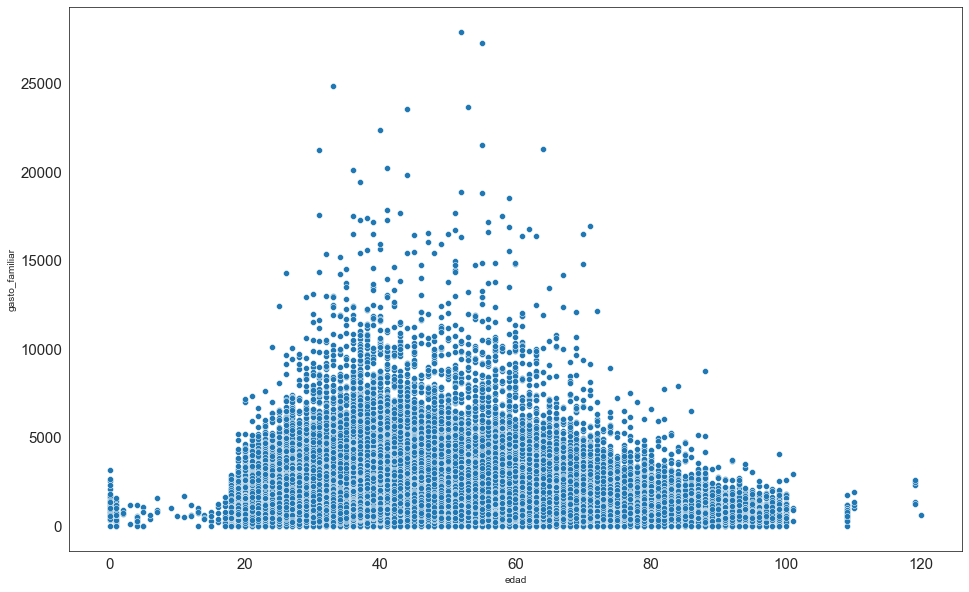

In [118]:
sns.scatterplot(bc_dataframe['edad'], np.sqrt(bc_dataframe['gasto_familiar']))

In [112]:
bc_dataframe[['edad', 'gasto_familiar']].corr()

,edad,gasto_familiar
edad,1.00000,0.03877
gasto_familiar,0.03877,1.00000


<AxesSubplot:xlabel='edad', ylabel='Density'>

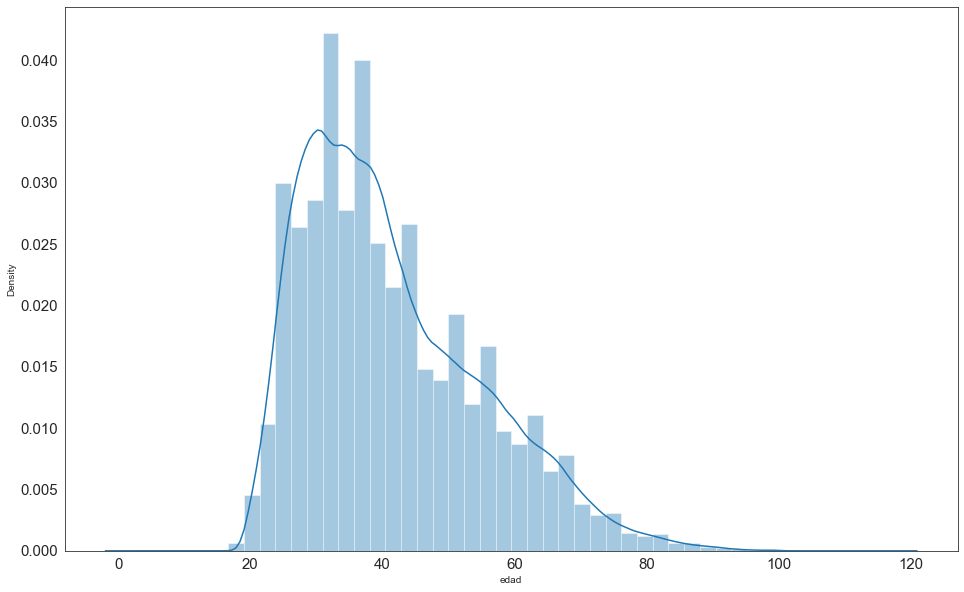

In [16]:
sns.distplot(bc_dataframe['edad'])

In [17]:
bc_dataframe['cupo_total_tc'].describe()

count     4197938.00000
mean      4428787.03945
std      10936162.05056
min             0.00000
25%             0.00000
50%             0.00000
75%       4700000.00000
max     966200000.00000
Name: cupo_total_tc, dtype: float64

<AxesSubplot:xlabel='cupo_total_tc', ylabel='Density'>

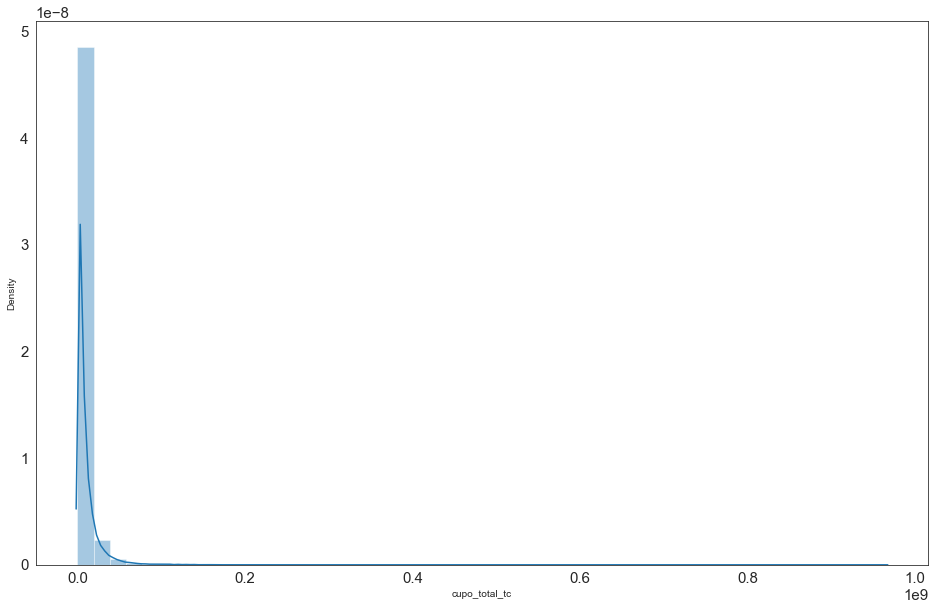

In [18]:
sns.distplot(bc_dataframe['cupo_total_tc'])

In [100]:
print(np.quantile(bc_dataframe['cant_oblig_tot_sf'], 0.99))
bc_dataframe['cant_oblig_tot_sf'].describe()

15.0


count   4197938.00000
mean          2.76423
std           3.41020
min           0.00000
25%           0.00000
50%           2.00000
75%           4.00000
max         152.00000
Name: cant_oblig_tot_sf, dtype: float64

In [113]:
bc_dataframe['ind_sin_gasto'] = bc_dataframe['ingreso_final'] -  bc_dataframe[[ 'cuota_de_vivienda', 'cuota_de_consumo', 'cuota_rotativos' , 
              'cuota_sector_real_comercio', 'cuota_tarjeta_de_credito', 'cuota_de_sector_solidario',
              'cuota_sector_real_comercio', 'cuota_libranza_sf']].sum(axis=1)
bc_dataframe[['ind_sin_gasto', 'gasto_familiar']].corr()

,ind_sin_gasto,gasto_familiar
ind_sin_gasto,1.00000,0.03246
gasto_familiar,0.03246,1.00000


In [115]:
bc_dataframe[[ 'cuota_de_vivienda', 'cuota_de_consumo', 'cuota_rotativos' , 
              'cuota_sector_real_comercio', 'cuota_tarjeta_de_credito', 'cuota_de_sector_solidario',
              'cuota_sector_real_comercio', 'cuota_libranza_sf']].sum(axis=1)

0         275000.00000
1              0.00000
2        2271000.00000
3        7754000.00000
4              0.00000
              ...     
220801   2304000.00000
220802         0.00000
220803   2574841.95000
220804         0.00000
220805    486000.00000
Length: 4197938, dtype: float64

In [116]:
bc_dataframe['ocupacion'].value_counts()

Empleado                     2576646
Independiente                 457612
Estudiante                    267000
Profesional Independiente     211789
Jubilado                      202657
Comerciante                   106078
Socio Empleado - Socio        100900
Ama de Casa                    89847
Otro                           54376
Rentista de Capital            39830
Pensionado                     39205
Sin Ocupacion Asignada         11731
Desempleado sin Ingresos       11580
Desempleado con Ingresos       11129
Ganadero                        9500
Agricultor                      6068
\N                              1935
Vacío                             55
Name: ocupacion, dtype: int64

In [196]:
filtered_dataframe = bc_dataframe[
            #(dataframe['edad'] < 100) & # Imputar a percentil 99
            (bc_dataframe['gasto_familiar'] > 40000) &
            #(dataframe['edad'] >=20) &
            (bc_dataframe['gasto_familiar'] < 30000000) &
            # (dataframe['cant_oblig_tot_sf'] < 13) &
            (bc_dataframe['cuota_de_consumo'] >= 0) & # Mas bien transformar a cero
            (bc_dataframe['ingreso_final'] < 50000000) &
            (bc_dataframe['cuota_cred_hipot'] >= 0) &
            (bc_dataframe['cupo_total_tc'] < 50000000) & # Percentil 99%
            (bc_dataframe['cuota_tc_bancolombia'] < 10000000) & # percentil 99.99%
            (bc_dataframe['cuota_de_vivienda'] < 10000000) &# Percentil 99.99%
            (bc_dataframe['cuota_de_consumo'] < 10000000) & # percentil 99%
            (bc_dataframe['cuota_rotativos'] < 10000000)& # percentil 99.99%
            (bc_dataframe['cuota_tarjeta_de_credito'] < 10000000) & 
            (bc_dataframe['cuota_de_sector_solidario'] < 10000000) &
            (bc_dataframe['cuota_sector_real_comercio'] < 13000000) &# Percentil 99.5%
            (bc_dataframe['cuota_libranza_sf'] < 5000000) & # Percentil 99
            (bc_dataframe['ingreso_segurida_social'] < 25000000) & # percentil 99.9
            (bc_dataframe['ingreso_nomina'] < 20000000) &
            (bc_dataframe['saldo_prom3_tdc_mdo'] < 30000000) &
            (bc_dataframe['saldo_no_rot_mdo'] < 300000000) &
            (bc_dataframe['cuota_cred_hipot'] < 10000000) &
            (bc_dataframe['mediana_nom3'] < 20000000) &
            (bc_dataframe['mediana_pen3'] < 11000000) &
            (bc_dataframe['cuota_tc_mdo'] < 30000000) &
            (bc_dataframe['ingreso_nompen'] < 3000000) &
            (bc_dataframe['cant_oblig_tot_sf'] <= 15) &
            (bc_dataframe['ctas_activas'] < 5) &
            (bc_dataframe['nro_tot_cuentas'] < 5) 
          #  ~(dataframe['departamento_residencia'].isin(['MADRID', 'ESTADO DE LA FLORIDA', 'VAUPES']))
        ] 
filtered_dataframe

,periodo,id_cli,edad,genero,estado_civil,nivel_academico,ocupacion,tipo_vivienda,ult_actual,categoria,ind_mora_vigente,departamento_residencia,mora_max,cupo_total_tc,tenencia_tc,cuota_tc_bancolombia,tiene_consumo,tiene_crediagil,nro_tot_cuentas,ctas_activas,tiene_ctas_activas,cuota_cred_hipot,mediana_nom3,mediana_pen3,ingreso_nompen,cat_ingreso,ingreso_final,cant_mora_30_tdc_ult_3m_sf,cant_mora_30_consum_ult_3m_sf,cuota_de_vivienda,cuota_de_consumo,cuota_rotativos,cuota_tarjeta_de_credito,cuota_de_sector_solidario,cuota_sector_real_comercio,cupo_tc_mdo,saldo_prom3_tdc_mdo,cuota_tc_mdo,saldo_no_rot_mdo,cuota_libranza_sf,cant_oblig_tot_sf,ind,rep_calif_cred,pol_centr_ext,convenio_lib,ingreso_nomina,ingreso_segurida_social,gasto_familiar,total_cuota,ingreso_calculado,ingreso_corr,cuota_cred_hipot_pct,cuota_tarjeta_de_credito_pct,cuota_de_consumo_pct,cuota_rotativos_pct,cuota_sector_real_comercio_pct,cuota_de_sector_solidario_pct,cuota_tc_bancolombia_pct,cuota_libranza_sf_pct,cupo_total_tc_pct,cupo_tc_mdo_pct,obl_total_pct,sobre_endeudado,gasto_pct,saldo_favor,cat_edad
0,201902,2897375,34,F,SOL,UNIVERSITARIO,Empleado,\N,20180526,1,N,VALLE,NApl,0.00000,0,0.00000,0,0,1,1,0,0.00000,0.00000,0.00000,0.00000,OTROS,2580312.00000,SIN MORA,SIN MORA,0.00000,220000.00000,0.00000,82000.00000,0.00000,0.00000,500000.00000,352500.00000,184000.00000,634000.00000,0.00000,2,1375202.80000,D,cumple,N,0.00000,0.00000,1932240.00000,384000.00000,0.00000,2580312.00000,0.00000,3.17791,8.52610,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,19.37750,11.70401,0,74.88397,0.00000,M30_40
1,201902,2586131,34,M,SOL,ESPECIALIZACION,Empleado,FAMILIAR,20180510,2,N,CUNDINAMARCA,Entre 0 y 30 dias,0.00000,0,0.00000,0,0,1,1,0,0.00000,0.00000,0.00000,0.00000,OTROS,898342.00000,SIN MORA,CON MORA,0.00000,442000.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,12682000.00000,0.00000,2,-60204.65000,H,NApl,N,0.00000,0.00000,534336.00000,442000.00000,0.00000,898342.00000,0.00000,0.00000,49.20175,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,49.20175,0,59.48024,0.00000,M30_40
2,201902,2586306,39,M,NI,NO INFORMA,Empleado,NO INFORMA,20180625,1,N,CUNDINAMARCA,Entre 0 y 30 dias,0.00000,0,0.00000,0,0,1,1,0,0.00000,1397155.00000,0.00000,1397155.00000,NOM,898277.00000,SIN MORA,SIN MORA,0.00000,0.00000,0.00000,0.00000,0.00000,356000.00000,1875000.00000,1406500.00000,150000.00000,15023000.00000,0.00000,1,4138.50000,G,cumple,S,897716.00000,0.00000,313246.00000,0.00000,1397155.00000,1397155.00000,0.00000,0.00000,0.00000,0.00000,25.48035,0.00000,0.00000,0.00000,0.00000,134.20129,25.48035,0,22.42028,0.00000,M30_40
3,201902,2892385,33,M,SOL,ESPECIALIZACION,Otro,FAMILIAR,20181106,2,N,HUILA,Entre 0 y 30 dias,6650000.00000,1,461176.58250,1,0,1,1,0,0.00000,0.00000,0.00000,0.00000,OTROS,11325895.00000,CON MORA,CON MORA,0.00000,2934000.00000,0.00000,4244000.00000,0.00000,288000.00000,20967000.00000,3171000.00000,8055000.00000,21225000.00000,0.00000,7,-727092.47500,H,NApl,N,0.00000,0.00000,562109.74000,11883176.58250,0.00000,11325895.00000,0.00000,37.47165,25.90524,0.00000,2.54285,0.00000,4.07188,0.00000,58.71501,185.12444,69.99161,0,4.96305,0.00000,M30_40
4,201902,2900599,57,M,SOL,SIN INFORMACION,Comerciante,\N,20181009,4,N,ATLANTICO,Entre 0 y 30 dias,0.00000,0,0.00000,0,0,1,1,0,0.00000,0.00000,0.00000,0.00000,OTROS,31793000.00000,NApl,NApl,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,20268037.50000,NApl,incumple,N,0.00000,0.00000,3683089.00000,0.00000,0.00000,31793000.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,11.58459,0.00000,M60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220887,202011,3493032,27,F,SOL,TECNOLOGO,Empleado,\N,20200902,1,N,ANTIOQUIA,Entre 0 

<AxesSubplot:xlabel='periodo'>

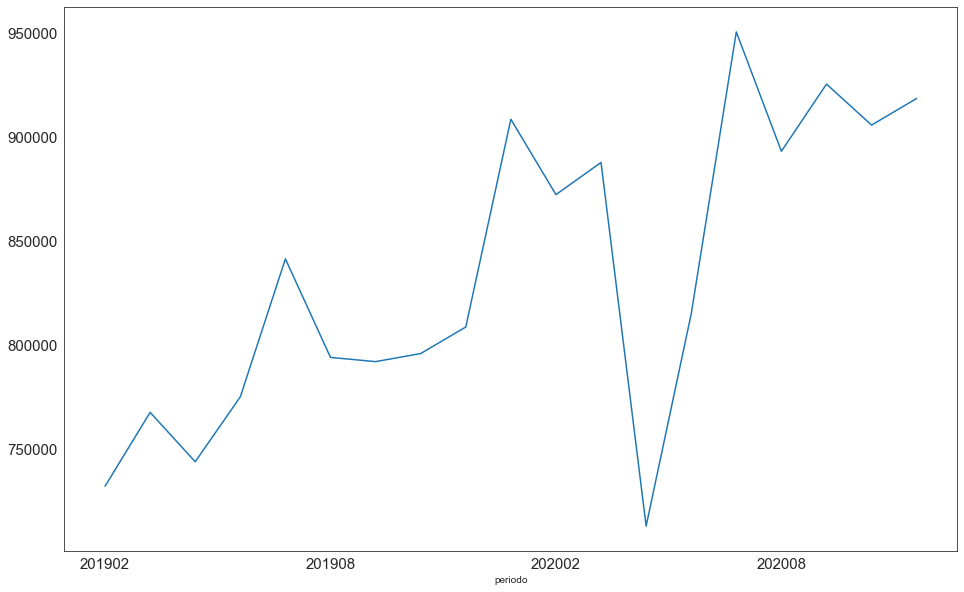

In [16]:
filtered_dataframe.groupby('periodo')['gasto_familiar'].mean().plot()

In [200]:
filtered_dataframe.groupby('periodo')['total_cuota'].median()

periodo
201902   380000.00000
201903   354000.00000
201904   382000.00000
201905   426000.00000
201907   422430.39175
201908   406845.40500
201909   415252.12425
201910   440000.00000
201911   450000.00000
202001   516000.00000
202002   509056.50000
202003   524000.00000
202004   532800.00000
202005   508296.00000
202007   547000.00000
202008   554000.00000
202009   418000.00000
202010   492000.00000
202011   494500.00000
Name: total_cuota, dtype: float64

<AxesSubplot:xlabel='periodo'>

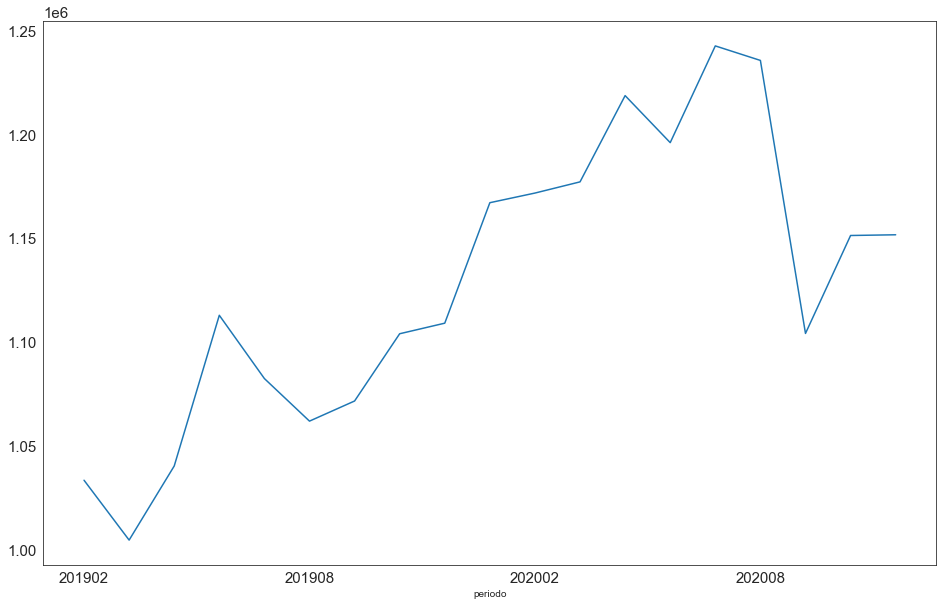

In [198]:
filtered_dataframe.groupby('periodo')['total_cuota'].mean().plot()

In [135]:
var='edad'
print("Correlacion variable natural: ")
print(np.corrcoef(bc_dataframe['gasto_familiar'], bc_dataframe[var]))
print("Correlacion variable Raiz: ")
print(np.corrcoef(bc_dataframe['gasto_familiar'], np.sqrt(bc_dataframe[var])))
print("Correlacion variable log: ")
print(np.corrcoef(bc_dataframe['gasto_familiar'], np.log1p(bc_dataframe[var])))



Correlacion variable natural: 
[[1.         0.03877215]
 [0.03877215 1.        ]]
Correlacion variable Raiz: 
[[1.         0.04338159]
 [0.04338159 1.        ]]
Correlacion variable log: 
[[1.         0.04726196]
 [0.04726196 1.        ]]


In [126]:
np.corrcoef(bc_dataframe['edad'], np.sqrt(bc_dataframe['total_cuota']))

array([[1.        , 0.07153299],
       [0.07153299, 1.        ]])

<AxesSubplot:xlabel='periodo'>

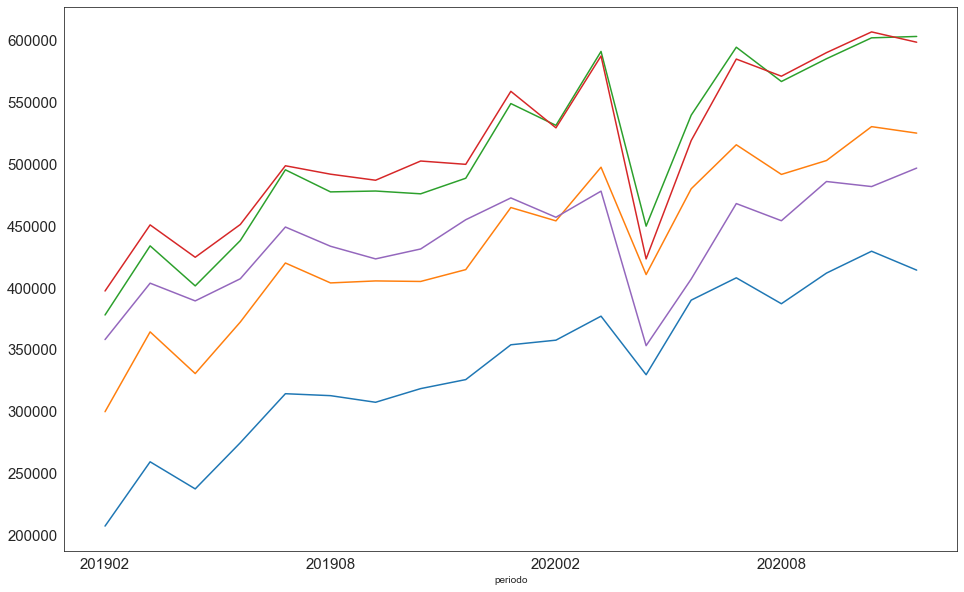

In [146]:
bc_dataframe[bc_dataframe['edad'] < 30].groupby('periodo')['gasto_familiar'].median().plot()
bc_dataframe[(bc_dataframe['edad'] < 40) &
            (bc_dataframe['edad'] >= 30)].groupby('periodo')['gasto_familiar'].median().plot()
bc_dataframe[(bc_dataframe['edad'] < 50) &
            (bc_dataframe['edad'] >= 40)].groupby('periodo')['gasto_familiar'].median().plot()
bc_dataframe[(bc_dataframe['edad'] < 60) &
            (bc_dataframe['edad'] >= 50)].groupby('periodo')['gasto_familiar'].median().plot()
bc_dataframe[(bc_dataframe['edad'] >= 60)].groupby('periodo')['gasto_familiar'].median().plot()

In [150]:
bc_dataframe['cat_edad'].value_counts()

M30_40    1372260
M60       1076895
M40_50     890572
M30        859337
Name: cat_edad, dtype: int64

<AxesSubplot:xlabel='cat_edad'>

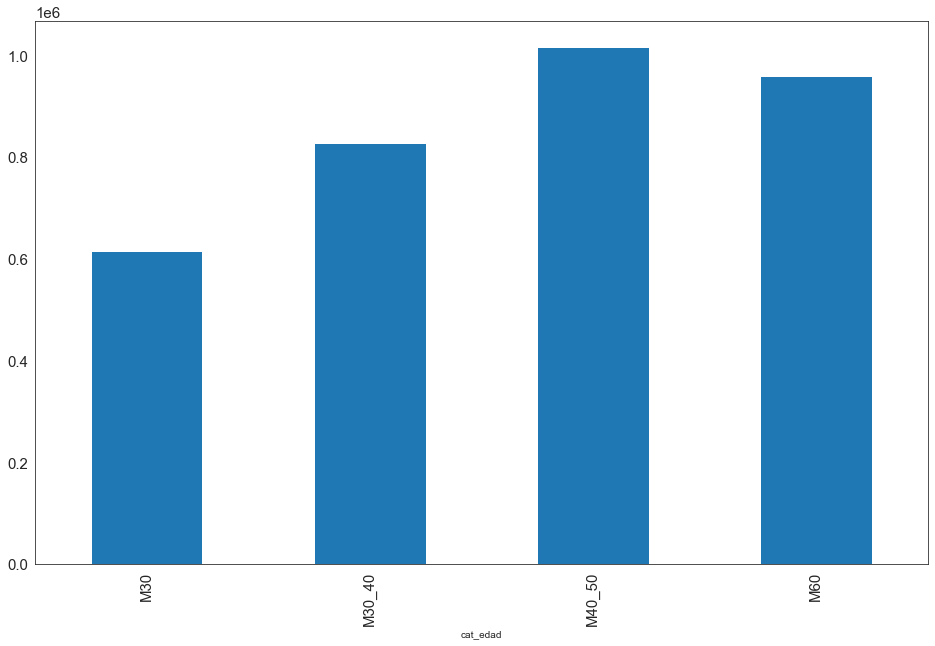

In [149]:
bc_dataframe.groupby('cat_edad')['gasto_familiar'].mean().plot(kind='bar')

In [151]:
bc_dataframe['estado_civil'].value_counts()

SOL     1900883
CAS     1157645
UL       491019
NI       381337
DIV      170300
VIU       71940
OTRO      25940
Name: estado_civil, dtype: int64

<AxesSubplot:xlabel='periodo'>

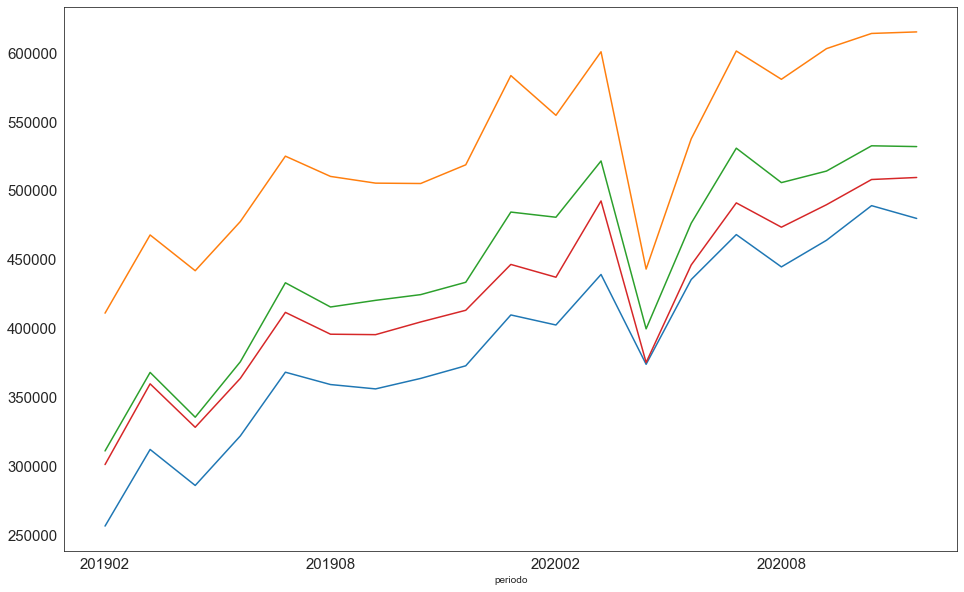

In [163]:
bc_dataframe[(bc_dataframe['estado_civil'] == 'SOL')].groupby('periodo')['gasto_familiar'].median().plot()
bc_dataframe[(bc_dataframe['estado_civil'] == 'CAS')].groupby('periodo')['gasto_familiar'].median().plot()
bc_dataframe[(bc_dataframe['estado_civil'] == 'UL')].groupby('periodo')['gasto_familiar'].median().plot()
#bc_dataframe[(bc_dataframe['estado_civil'] == 'DIV')].groupby('periodo')['gasto_familiar'].mean().plot()
bc_dataframe[(bc_dataframe['estado_civil'].isin(['NI', 'VIU', 'OTRO', 'NI', 'DIV']))].groupby('periodo')['gasto_familiar'].median().plot()

In [162]:
bc_dataframe['nivel_academico'].value_counts()

UNIVERSITARIO      1523614
NO INFORMA          657552
SIN INFORMACION     565323
TECNOLOGO           554383
BACHILLER           466992
ESPECIALIZACION     328880
PRIMARIO             58900
NINGUNO              43420
Name: nivel_academico, dtype: int64

<AxesSubplot:xlabel='periodo'>

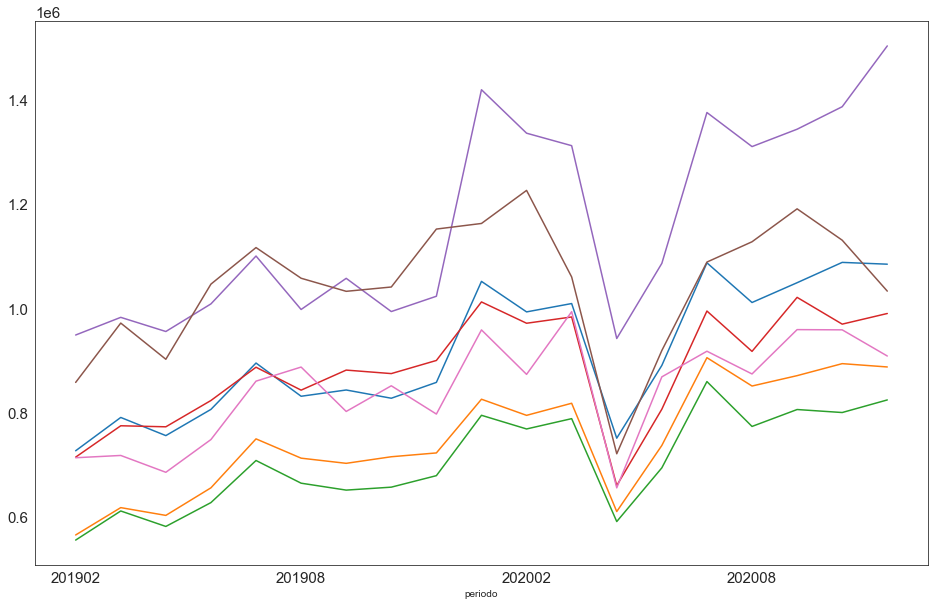

In [170]:
bc_dataframe[(bc_dataframe['nivel_academico'] == 'UNIVERSITARIO')].groupby('periodo')['gasto_familiar'].mean().plot()
bc_dataframe[(bc_dataframe['nivel_academico'].isin(['NO INFORMA', 'SIN INFORMACION']))].groupby('periodo')['gasto_familiar'].mean().plot()
bc_dataframe[(bc_dataframe['nivel_academico'] == 'TECNOLOGO')].groupby('periodo')['gasto_familiar'].mean().plot()
bc_dataframe[(bc_dataframe['nivel_academico'] == 'BACHILLER')].groupby('periodo')['gasto_familiar'].mean().plot()
bc_dataframe[(bc_dataframe['nivel_academico'] == 'ESPECIALIZACION')].groupby('periodo')['gasto_familiar'].mean().plot()
bc_dataframe[(bc_dataframe['nivel_academico'] == 'PRIMARIO')].groupby('periodo')['gasto_familiar'].mean().plot()
bc_dataframe[(bc_dataframe['nivel_academico'] == 'NINGUNO')].groupby('periodo')['gasto_familiar'].mean().plot()

# NO ES CLARA LA SEPARACION, REVISAR BIEN



In [171]:
bc_dataframe['ocupacion'].value_counts()

Empleado                     2576166
Independiente                 458143
Estudiante                    267228
Profesional Independiente     212100
Jubilado                      202777
Comerciante                   106390
Socio Empleado - Socio        100587
Ama de Casa                    89989
Otro                           54585
Rentista de Capital            39990
Pensionado                     39098
Desempleado sin Ingresos       11822
Sin Ocupacion Asignada         11755
Desempleado con Ingresos       11069
Ganadero                        9413
Agricultor                      5979
\N                              1915
Vacío                             58
Name: ocupacion, dtype: int64

<AxesSubplot:xlabel='periodo'>

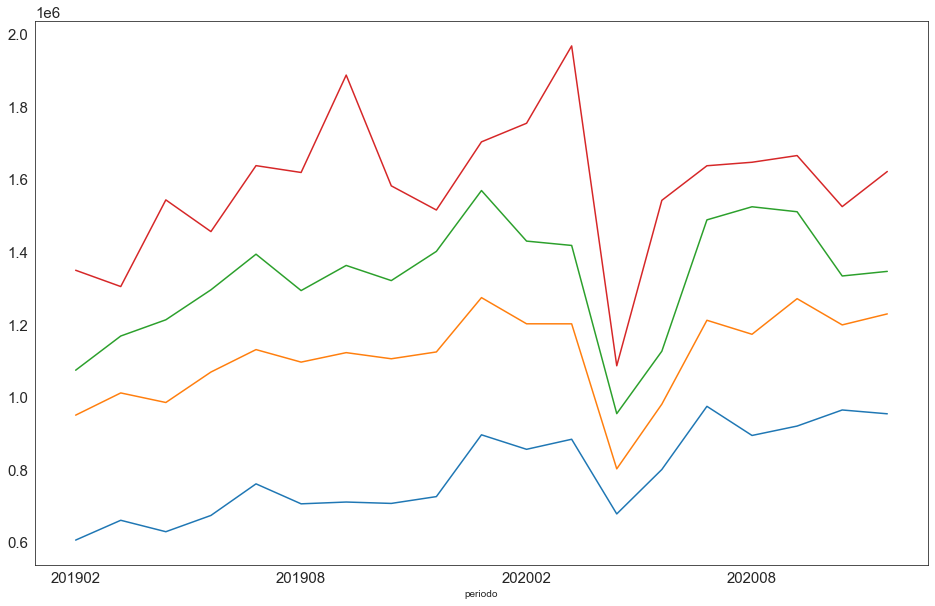

In [182]:
bc_dataframe[(bc_dataframe['ocupacion'] == 'Empleado')].groupby('periodo')['gasto_familiar'].mean().plot()
bc_dataframe[(bc_dataframe['ocupacion'].isin(['Independiente', 'Profesional Independiente']))].groupby('periodo')['gasto_familiar'].mean().plot()
bc_dataframe[(bc_dataframe['ocupacion'] == 'Comerciante')].groupby('periodo')['gasto_familiar'].mean().plot()
bc_dataframe[(bc_dataframe['ocupacion'].isin(['Ganadero', 'Agricultor']))].groupby('periodo')['gasto_familiar'].mean().plot()
# Hacer algunas uniones pero revisar antes de incluir en el modelo


In [183]:
bc_dataframe['tipo_vivienda'].value_counts()

\N            2002579
FAMILIAR       975175
PROPIA         684065
ALQUILADA      362474
NO INFORMA     174771
Name: tipo_vivienda, dtype: int64

<AxesSubplot:xlabel='periodo'>

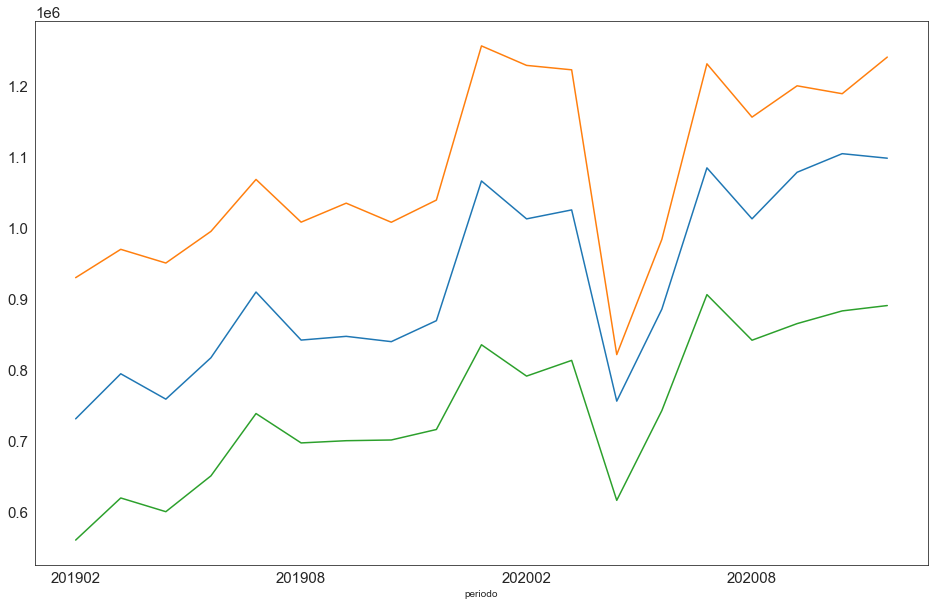

In [191]:
bc_dataframe[(bc_dataframe['tipo_vivienda'].isin(['FAMILIAR', 'ALQUILADA']) )].groupby('periodo')['gasto_familiar'].mean().plot()
bc_dataframe[(bc_dataframe['tipo_vivienda'] == 'PROPIA')].groupby('periodo')['gasto_familiar'].mean().plot()
bc_dataframe[(bc_dataframe['tipo_vivienda'].isin(['NO INFORMA', '\\N']) )].groupby('periodo')['gasto_familiar'].mean().plot()

## AGRUPAR Y PROBAR

<AxesSubplot:xlabel='gasto_familiar', ylabel='Density'>

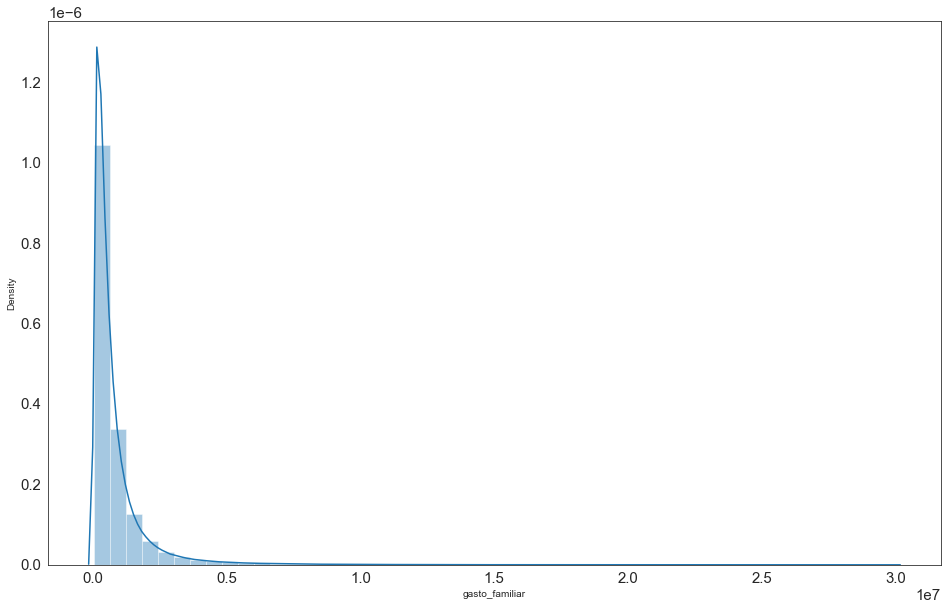

In [120]:
sns.distplot(filtered_dataframe['gasto_familiar'])

<AxesSubplot:xlabel='cuota_de_consumo', ylabel='Density'>

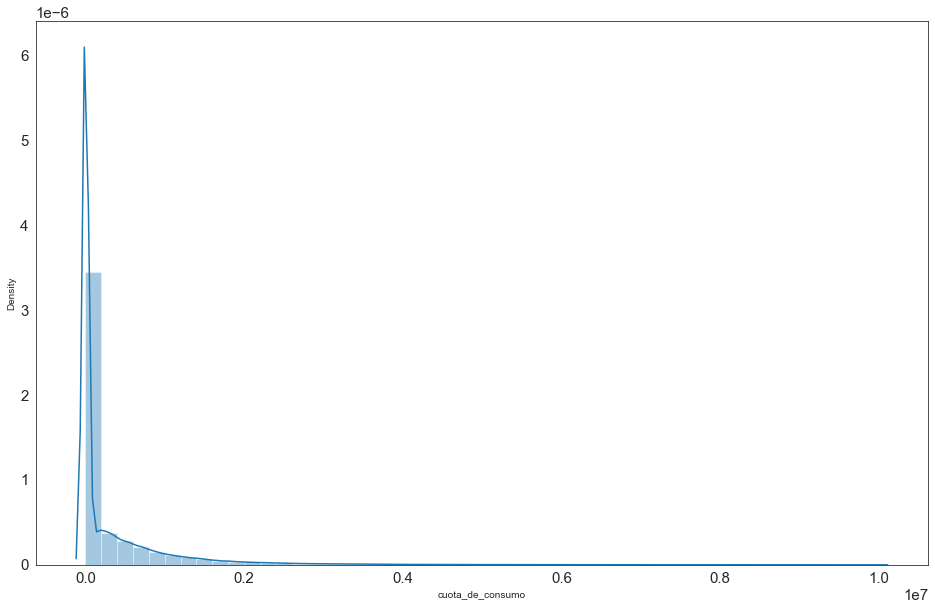

In [121]:
sns.distplot(filtered_dataframe['cuota_de_consumo'])